In [1]:
#%%capture
!pip install setuptools==65.5.0 "wheel<0.40.0"
!apt update
!apt-get install python3-opengl
!apt install xvfb -y
!pip install 'swig'
!pip install 'pyglet==1.5.27'
!pip install 'gym[box2d]==0.20.0'
!pip install 'pyvirtualdisplay==3.0'


import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
from torch.distributions import Normal
from torch.optim import Adam
import os
%matplotlib inline

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
plot_interval = 10 # update the plot every 10 episodes
video_every = 50 # videos can take a very long time to render so only do it every 100 episodes

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
# code taken from here -> https://github.com/pranz24/pytorch-soft-actor-critic/
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)
        
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)
        
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()

        #Q1 architecture
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        #Q2 architecture
        self.linear4 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear5 = nn.Linear(hidden_dim, hidden_dim)
        self.linear6 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state, action):
        
        xu = torch.cat([state, action], 1)
        
        x1 = F.relu(self.linear1(xu))
        x1 = F.relu(self.linear2(x1))
        x1 = self.linear3(x1)

        x2 = F.relu(self.linear4(xu))
        x2 = F.relu(self.linear5(x2))
        x2 = self.linear6(x2)

        return x1, x2

class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(GaussianPolicy, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

        if action_space is None:
            self.action_scale = torch.tensor(1.)
            self.action_bias = torch.tensor(0.)
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.high - action_space.low) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.high + action_space.low) / 2.)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)

        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super(GaussianPolicy, self).to(device) 
    
class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

        if action_space is None:
            self.action_scale = 1.
            self.action_bias = 0.
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.high - action_space.low) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.high + action_space.low) / 2.)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = torch.tanh(self.mean(x)) * self.action_scale + self.action_bias
        return mean

    def sample(self, state):
        mean = self.forward(state)
        noise = self.noise.normal_(0., std=0.1)
        noise = noise.clamp(-0.25, 0.25)
        action = mean + noise
        return action, torch.tensor(0.), mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        self.noise = self.noise.to(device)
        return super(DeterministicPolicy, self).to(device)
    
class ReplayMemory:
    def __init__(self, capacity, seed, beta_start=1.0, beta_end=0.1, total_episodes=1000, evaluation_window=100):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.total_episodes = total_episodes
        self.current_episode = 0
        self.evaluation_window = evaluation_window
        self.rewards = []

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
        self.rewards.append(reward)

    def sample(self, batch_size):
        recent_rewards = self.rewards[-self.evaluation_window:]
        reward_variability = np.std(recent_rewards)
        adaptive_factor = max(0.1, 1 - reward_variability)  
        
        beta = self.beta_end + (self.beta_start - self.beta_end) * adaptive_factor
        beta = max(self.beta_end, min(self.beta_start, beta))  
        
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def update_episode(self):
        self.current_episode += 1
        if len(self.rewards) > self.evaluation_window * 10:  
            self.rewards = self.rewards[-self.evaluation_window * 10:]

    def __len__(self):
        return len(self.buffer)

    def save_buffer(self, env_name, suffix="", save_path=None):
        if not os.path.exists('checkpoints/'):
            os.makedirs('checkpoints/')

        if save_path is None:
            save_path = "checkpoints/sac_buffer_{}_{}".format(env_name, suffix)
        print('Saving buffer to {}'.format(save_path))

        with open(save_path, 'wb') as f:
            pickle.dump(self.buffer, f)

    def load_buffer(self, save_path):
        print('Loading buffer from {}'.format(save_path))

        with open(save_path, "rb") as f:
            self.buffer = pickle.load(f)
            self.position = len(self.buffer) % self.capacity
            



In [5]:
class SAC(object):
    def __init__(self, num_inputs, action_space, \
                 device, hidden_size, lr, gamma, tau, alpha):

        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha

        self.device = device 

        self.critic = QNetwork(num_inputs, action_space.shape[0], hidden_size).to(device=self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=lr)

        self.critic_target = QNetwork(num_inputs, action_space.shape[0], hidden_size).to(self.device)
        hard_update(self.critic_target, self.critic)
        
        self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(self.device)).item()
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optim = Adam([self.log_alpha], lr=lr)
        self.policy = GaussianPolicy(num_inputs, action_space.shape[0], \
                                         hidden_size, action_space).to(self.device)
        self.policy_optim = Adam(self.policy.parameters(), lr=lr)

    
    def select_action(self, state, eval=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        if eval == False:
            action, _, _ = self.policy.sample(state)
        else:
            _, _, action = self.policy.sample(state)
        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size):
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)


        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * (min_qf_next_target)

        qf1, qf2 = self.critic(state_batch, action_batch)
        qf1_loss = F.mse_loss(qf1, next_q_value)
        qf2_loss = F.mse_loss(qf2, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)
        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)
        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean()

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()
        self.alpha_optim.zero_grad()
        alpha_loss.backward()
        self.alpha_optim.step()
        self.alpha = self.log_alpha.exp()

        soft_update(self.critic_target, self.critic, self.tau)

In [7]:
%%capture
env = gym.make("BipedalWalker-v3")
#env = gym.make("BipedalWalkerHardcore-v3") # only attempt this when your agent has solved BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)


obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]


seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

In [8]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

In [9]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

The environment has 24 observations and the agent can take 4 actions
The device is: cuda


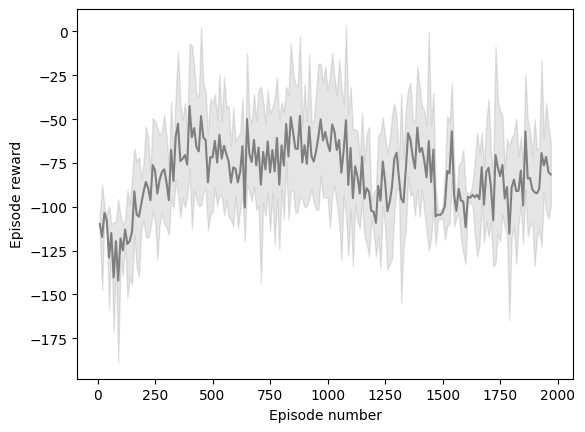

In [ ]:

lr=7.3e-04      # Values taken from here -> https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/hyperparams/sac.yml
batch_size=256
hidden_size = 400
tau=0.02  #0.01 hardcore
gamma=0.98  #0.99 hardcore
alpha=0.2 
start_steps=10000
update_start_steps=1e4
reward_scale = 10 
test_ep = 10 
max_timesteps = 2000
capacity = 1000000 
seed = 42
max_episodes = 3000
evaluation_window = 25

agent = SAC(obs_dim, env.action_space, device, hidden_size, lr, gamma, tau, alpha)
replay_buffer = ReplayMemory(capacity, seed, beta_start=1.0, beta_end=0.1, total_episodes=max_episodes, evaluation_window=evaluation_window)
total_steps = 0 
log_f = open("agent-log.txt","w+")
reward_list = []
plot_data = []

for episode in range(1, max_episodes+1):

    ep_r = 0
    ep_s = 0
    done = False
    state = env.reset()
    

    
    while not done:

        action = []
        
        if total_steps < start_steps:
            action = env.action_space.sample()
        else:
            use_eval = False
            if episode % (test_ep*2) >= test_ep:
                use_eval = True
            action = agent.select_action(state, use_eval)
            
        next_state, reward, done, info = env.step(action)
        ep_r += reward
        reward = reward * reward_scale

        ep_s += 1
        total_steps += 1
        
        mask = 1 if (ep_s == 1600) else float(not done)
        
        replay_buffer.push(state, action, reward, next_state, mask)

        state = next_state

        if ep_s > max_timesteps:
            break
    for _ in range(ep_s):
        if len(replay_buffer) >= update_start_steps:
            agent.update_parameters(replay_buffer, batch_size)
    
    # do NOT change this logging code - it is used for automated marking!
    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_r))
    log_f.flush()
  
    reward_list.append(ep_r)

    # plot graph
    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(reward_list).mean(), np.array(reward_list).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.show()
        disp.clear_output(wait=True)